In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
C96hAEL = '#F9F06C'
C120hAEL = '#EBA434'
Cupcrawling = '#414042'
CwhitePupa = '#003399'
C2hAPF = '#0080FF'
C4hAPF = '#33FFFF'
C6hAPF = '#71C382'
CecadGFPnbG4 = '#404040'
CecadGFPnbG4myoVI = '#0099CC'


colors = {'ecadGFPnbG4': CecadGFPnbG4,
          'ecadGFPnbG4myoVI': CecadGFPnbG4myoVI,
          '96hAEL': C96hAEL,
          '120hAEL':C120hAEL,
          'wL3': Cupcrawling,
          '0hAPF': CwhitePupa,
          '2hAPF': C2hAPF,
          '4hAPF': C4hAPF,
          '6hAPF': C6hAPF,
          'initial': 'gray',
          'final':'#EBA434'
 }




In [3]:
devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }

rois = ['outDV', 'DV']
devstages = ["wL3","0hAPF","2hAPF","4hAPF","6hAPF"]


In [4]:
import os
import pwd
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib  as mpl
import pickle
import csv
from matplotlib import pyplot

username = pwd.getpwuid( os.getuid() )[0]
codeRepo = '/Users/abhijeet.krishna/Documents/PhD/WDrevisions/WDeversion_theory/'
#sys.path.insert(0, codeRepo + '/CurvedTM/')



In [ ]:

# Load Curved Tissue Miner packages
import curvedtm
# sys.path.remove('/Users/fuhrmann/data/WDeversion_paper/CurvedTM/')
# sys.path.remove('/Users/fuhrmann/data/WDeversion_paper/wdanalysis/CurvedTM/CurvedTM_notebooks/TissueShapeAnalysis/modelresults')
sys.path.insert(0, codeRepo + '/CurvedTM/')

from curvedtm import Ntools 
from curvedtm import calculateQrr

In [11]:
# from wd_2D_functions import *
# from tissueShape_JF import *
dataout = '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/plotting/PaperPlots/TissueShapeAnalysis'
os.makedirs(dataout,exist_ok=True)
import pickle

In [12]:
plt.style.use('/Users/fuhrmann/mambaforge/pkgs/matplotlib-base-3.6.3-py39hb2f573b_0/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-custom-whitegrid.mplstyle')

### def

In [7]:
def piecewise_linear_interpolate(xs_interpolated, xs, ys, manner = 'linear', include_zero = False):
    
    #assuming that xs are sorted
    #we want to know first the index i of xs for which xs[i + 1] >= x > xs[i]
    
    if include_zero:
        xs = np.array(xs)
        ys = np.array(ys)
        xs = xs.insert(xs, 0, 0) #0 included at beginning
        ys = ys.insert(ys, 0, 0) #0 included at beginning
    
    indexes = np.searchsorted(a = xs, v = xs_interpolated, side = 'right')  #function tells you the index where the element v should go to maintain the order of a. ##side does not matter if y(x) is continuous 
    #print('indexes')
    #print(indexes)
    ys_interpolated = []
    
    if indexes.shape == 1:
        indexes = [indexes]
        
    for ctr in range(len(indexes)):
        
        i = indexes[ctr]
        x_interpolated = xs_interpolated[ctr]
        if manner == 'linear':
        	i = i-1
        if manner == 'step-backward':
        	i = i-1
        # if manner is step-forward then i remains i
        
        if (i >= len(xs) - 1) or (i < 0):
            #special boundary cases
            if x_interpolated == xs[0]:
                y_interpolated = ys[0]
                ys_interpolated.append(y_interpolated)
                continue
            elif ((manner == 'linear') or (manner == 'step-backward')) and (x_interpolated == xs[len(xs)-1]):
                y_interpolated = ys[len(xs)-1]
                ys_interpolated.append(y_interpolated)
                continue 
            elif (manner == 'step-forward') and (x_interpolated == xs[len(xs)-2]):
                y_interpolated = ys[len(xs)-2]
                ys_interpolated.append(y_interpolated)
                continue 
            elif (manner == 'step-forward') and (x_interpolated <= xs[len(xs)-1]):
                y_interpolated = ys[len(xs)-1]
                ys_interpolated.append(y_interpolated)
                continue 
            else:
                #print('cannot interpolate outside the domain of x values')
                #print(x_interpolated)
                y_interpolated = None
                ys_interpolated.append(y_interpolated)
                continue
            
        if manner == 'linear':
            slope = (ys[i + 1] - ys[i])/(xs[i + 1] - xs[i])
        elif 'step' in manner:
            slope = 0
            
        y_interpolated = ys[i] + (x_interpolated - xs[i])*slope
        ys_interpolated.append(y_interpolated)
        
    if len(ys_interpolated) == 1:
        return(ys_interpolated[0])

    return(np.array(ys_interpolated))

## WT results

### data

In [13]:
#Dataframe that contains all crossections from ecadGFPnbG4 and ecadGFPnbG4myoVI
with open('allshapeswStats.pkl','rb') as f:
        df_mean_all = pickle.load(f)

print('data for the following genotypes is available: '+ str(np.unique(df_mean_all['genotype'])))
genotype='ecadGFPnbG4'
df_mean_all["devstage"] = [devstage_map[x] for x in df_mean_all["devstage"].values]
df_mean = df_mean_all.loc[df_mean_all['genotype']==genotype]

data for the following genotypes is available: ['ecadGFPnbG4' 'ecadGFPnbG4myoVI']


In [14]:
limits = df_mean_all.groupby(['devstage','genotype'])['arclength'].agg(['max','min']).reset_index()
df_mean_all10p = df_mean_all.merge(limits).drop_duplicates()
df_mean_all10p = df_mean_all10p.loc[(df_mean_all10p['arclength']>=df_mean_all10p['min']+50) & (df_mean_all10p['arclength']<=df_mean_all10p['max']-50)].drop(columns=['min', 'max'])  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


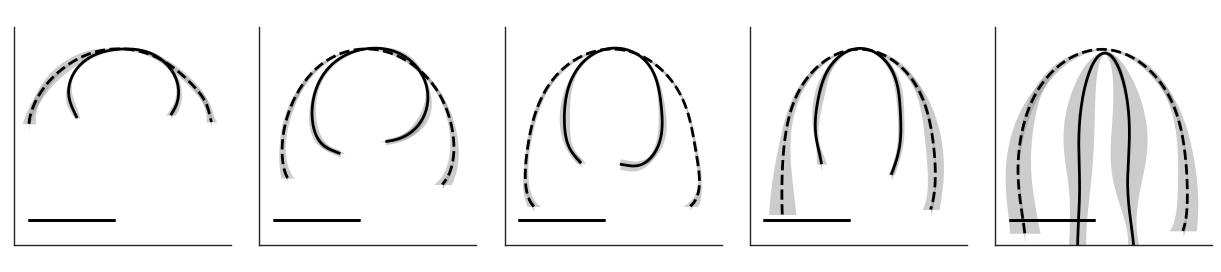

In [15]:
for genotype in ['ecadGFPnbG4']:

    if genotype == 'ecadGFPnbG4myoVI':
        devstages = ['wL3', '0hAPF', '2hAPF', '4hAPF', '6hAPF']
    else:
        devstages = ['wL3','0hAPF', '2hAPF', '4hAPF', '6hAPF']

    nbcols = len(devstages) 

    for prop in ['shape']:
        fig,axs = plt.subplots(1, nbcols,
                        figsize = (2.5*nbcols, (12/4)*1)
                        )

        main_ax = fig.add_subplot(111, frameon=False)
        if prop == 'shape':
                for region in ['acrossDV','alongDV']:
                    if region == 'alongDV': 
                        style = '--' 
                    else:
                        style = '-'
                    
                    data = df_mean_all.loc[df_mean_all['genotype']==genotype]
                    g = data[data['region']==region]

                    for j in range(0,len(devstages[0:])):
                        devstage = devstages[j]
                        plot =  g.loc[g['devstage']==devstage]
                    
                        plot = plot[['region', 'devstage', 'y_mean', 'x_mean', 'y_std' , 'x_std']].drop_duplicates()
                        
                        axs[j].fill_between(x = plot['x_mean'], y1 = plot['y' + '_mean']+plot['y' + '_std'], y2 = plot['y' + '_mean']-plot['y' + '_std'], color = 'gray', alpha = 0.4,lw =0.0)
                        axs[j].fill_betweenx(y = plot['y_mean'], x1 = plot['x' + '_mean']+plot['x' + '_std'], x2 = plot['x' + '_mean']-plot['x' + '_std'], color = 'gray', alpha = 0.4, lw =0.0)
                
                        axs[j].plot(plot['x_mean'], plot['y_mean'], color = 'black', linewidth =2, linestyle = style )



                        axs[j].set_xlim(-125,125)
                        axs[j].set_ylim(-225,25)
                        axs[j].set_yticks([])
                        axs[j].set_xticks([])

                        #adding scale bar
                        axs[j].plot([-125*7/8, -125*7/8+100],[-225*7/8,-225*7/8], lw = 2, color = 'black')      
                        axs[j].set_aspect('equal')          
                ax = main_ax

                ax.set_yticks([])
                ax.set_xticks([])
                ax.set_xlabel('')
                ax.set_ylabel('')
                ax.legend().set_visible(False)
                plt.tight_layout()
                plt.savefig(dataout + '/'  + 'tissue' + prop + '_compareDV-PD_900um_std_' + 'all_' + genotype + '.pdf',dpi=300, bbox_inches = "tight")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


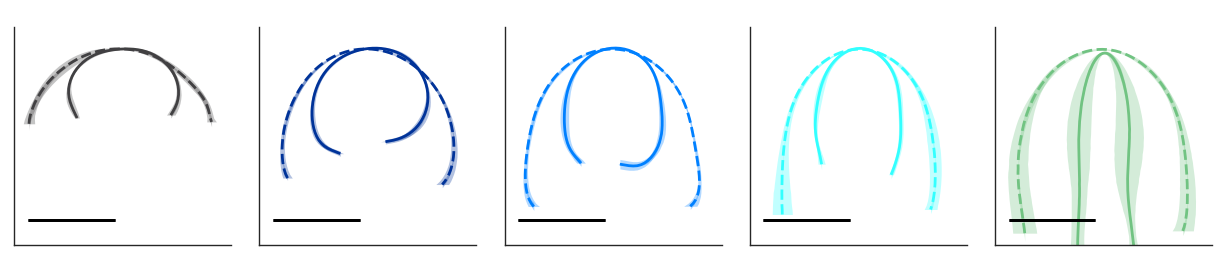

In [19]:
for genotype in ['ecadGFPnbG4']:

    if genotype == 'ecadGFPnbG4myoVI':
        devstages = ['wL3', '0hAPF', '2hAPF', '4hAPF', '6hAPF']
    else:
        devstages = ['wL3','0hAPF', '2hAPF', '4hAPF', '6hAPF']

    nbcols = len(devstages) 

    for prop in ['shape']:
        fig,axs = plt.subplots(1, nbcols,
                        figsize = (2.5*nbcols, (12/4)*1)
                        )

        main_ax = fig.add_subplot(111, frameon=False)
        if prop == 'shape':
                for region in ['acrossDV','alongDV']:
                    if region == 'alongDV': 
                        style = '--' 
                    else:
                        style = '-'
                    
                    data = df_mean_all.loc[df_mean_all['genotype']==genotype]
                    g = data[data['region']==region]

                    for j in range(0,len(devstages[0:])):
                        devstage = devstages[j]
                        plot =  g.loc[g['devstage']==devstage]
                    
                        plot = plot[['region', 'devstage', 'y_plugInMean', 'x_plugInMean', 'y_conf_int95' , 'x_conf_int95']].drop_duplicates()
                        
                        axs[j].fill_between(x = plot['x_plugInMean'], y1 = plot['y' + '_plugInMean']+plot['y' + '_conf_int95'], y2 = plot['y' + '_plugInMean']-plot['y' + '_conf_int95'], color = colors[devstage], alpha = 0.3,lw =0.0)
                        axs[j].fill_betweenx(y = plot['y_plugInMean'], x1 = plot['x' + '_plugInMean']+plot['x' + '_conf_int95'], x2 = plot['x' + '_plugInMean']-plot['x' + '_conf_int95'], color = colors[devstage], alpha = 0.3, lw =0.0)
                
                        axs[j].plot(plot['x_plugInMean'], plot['y_plugInMean'], color = colors[devstage], linewidth =2, linestyle = style )



                        axs[j].set_xlim(-125,125)
                        axs[j].set_ylim(-225,25)
                        axs[j].set_yticks([])
                        axs[j].set_xticks([])

                        #adding scale bar
                        axs[j].plot([-125*7/8, -125*7/8+100],[-225*7/8,-225*7/8], lw = 2, color = 'black')      
                        axs[j].set_aspect('equal')              
                        
                ax = main_ax

                ax.set_yticks([])
                ax.set_xticks([])
                ax.set_xlabel('')
                ax.set_ylabel('')
                ax.legend().set_visible(False)
                plt.tight_layout()
                plt.savefig(dataout + '/'  + 'tissue' + prop + '_compareDV-PD_900um_95confInt_' + 'all_' + genotype + '.pdf',dpi=300, bbox_inches = "tight")


In [16]:
df_mean = df_mean[['arclength','devstage','x_mean','y_mean','x_std','y_std','curvature_mean','curvature_std','region']]

In [16]:
### Set path to directory containing the Tissue Miner movies
import os
datapath_base = '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/data/'

with open(datapath_base + 'DFallDiscs' + 'limitcounts.pkl','rb') as f:
   allDiscsSorted = pickle.load(f)
allDiscsSorted = allDiscsSorted[allDiscsSorted['genotype'] == genotype]
allDiscsSorted["devstage"] = [devstage_map[x] for x in allDiscsSorted["devstage"].values]



In [18]:
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['dorsal','ventral']),'region'] = 'outDV'
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['DV']),'region'] = 'DV'

cellshapes = allDiscsSorted[(allDiscsSorted['genotype']==genotype)]
cellshapes = cellshapes.groupby(['devstage','discName','k_dist','region'])['k_dist_pathlength'].agg('mean').reset_index()
cellshapes = cellshapes.groupby(['devstage','discName','region'])['k_dist_pathlength'].agg('max').reset_index()

cellshapes = cellshapes.groupby(['devstage','region'])['k_dist_pathlength'].agg(['mean','std']).reset_index().rename(columns = {'mean':'maxPathlength'})

# if orientation == 'Across_DV':
with open(datapath_base+ 'DVboundaryWidth.pkl','rb') as f:
                DVwidth = pickle.load(f)
DVwidth = DVwidth[DVwidth['genotype']==genotype].groupby(['devstage'])['pathlengthUM'].agg(['mean']).rename(columns={'mean':'meanDVwidth'}).reset_index()
DVwidth["devstage"] = [devstage_map[x] for x in DVwidth["devstage"].values]
cellshapes = cellshapes.merge(DVwidth)
cellshapes.loc[cellshapes['region']=='outDV', 'maxPathlength'] = cellshapes['maxPathlength'] + (1/2*cellshapes['meanDVwidth'])
cellshapes.loc[cellshapes['region']=='DV','region'] = 'alongDV'
cellshapes.loc[cellshapes['region']=='outDV','region'] = 'acrossDV'

df_mean_all_trunkated = df_mean.merge(cellshapes)
df_mean_all_trunkated['trunkated'] = np.where((abs(df_mean_all_trunkated['arclength']) <= (df_mean_all_trunkated['maxPathlength']+df_mean_all_trunkated['std'])), 'keep', np.nan)
df_mean_all_trunkated = df_mean_all_trunkated[df_mean_all_trunkated['trunkated']=='keep'].drop(columns=['trunkated'])            
df_mean_all_trunkated = df_mean_all_trunkated.drop(columns=['std','meanDVwidth','maxPathlength'])

df_mean_all_trunkated = df_mean_all_trunkated.sort_values('arclength')
df_mean_all_trunkated = df_mean_all_trunkated.drop_duplicates()

In [17]:
df_mean_all_trunkated

NameError: name 'df_mean_all_trunkated' is not defined

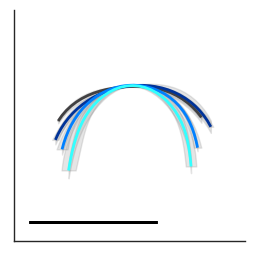

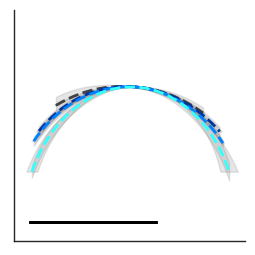

In [22]:

for region in ['acrossDV','alongDV']:
    fig, ax = plt.subplots(figsize = (3,3))
    
    for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
    
        if region == 'alongDV': 
                style = '--' 
        else:
            style = '-'
        if devstage  == 'wL3':
            c = 'initial'
        elif devstage == '4hAPF':
            c = 'final'

        toplot = df_mean_all_trunkated.loc[(df_mean_all_trunkated['devstage']==devstage)&(df_mean_all_trunkated['region']==region)]
        ax.plot(toplot['x_mean'],toplot['y_mean'], color = colors[devstage], linestyle = style,lw = 2)
        ax.fill_between(toplot['x_mean'],y1 = toplot['y_mean']-toplot['y_std'],y2 = toplot['y_mean']+toplot['y_std'], color = 'grey', alpha = 0.2)
        ax.fill_betweenx(y = toplot['y_mean'],x1 = toplot['x_mean']-toplot['x_std'],x2 = toplot['x_mean']+toplot['x_std'], color = 'grey', alpha = 0.2)

        ax.set_xlim(-90,90)
        ax.set_ylim(-120,60)
        ax.set_yticks([])
        ax.set_xticks([])
        # ax.spines['top'].set_visible(True)
        # ax.spines['right'].set_visible(True)
        #adding scale bar
        ax.plot([-90*7/8, -90*7/8+100],[-120*7/8,-120*7/8], lw = 2, color = 'black')      
        ax.set_aspect('equal')
    plt.savefig(dataout + region + '_shapeOverlay_eversion_trunkated.pdf', dpi = 600, bbox_inches = 'tight')

In [21]:
plt.style.use('/Users/fuhrmann/mambaforge/pkgs/matplotlib-base-3.6.3-py39hb2f573b_0/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-custom-whitegrid.mplstyle')

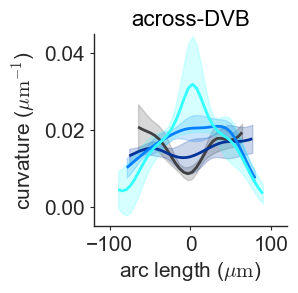

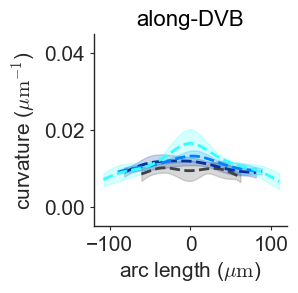

In [23]:
for region in ['acrossDV','alongDV']:
    fig, ax = plt.subplots(figsize = (2.5,2.5))
    for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
   
        if region == 'alongDV': 
                style = '--' 
                title = 'along-DVB'
        else:
            style = '-'  
            title = 'across-DVB'

        toplot = df_mean_all_trunkated.loc[(df_mean_all_trunkated['devstage']==devstage)&(df_mean_all_trunkated['region']==region)]
        ax.plot(toplot['arclength'],toplot['curvature_mean'], color = colors[devstage], linestyle = style,lw = 2)
        ax.fill_between(toplot['arclength'],y1 = toplot['curvature_mean']-toplot['curvature_std'],y2 = toplot['curvature_mean']+toplot['curvature_std'], color = colors[devstage], alpha = 0.2)

        ax.set_xlim(-120,120)
        ax.set_ylim(-0.005,0.045)
        
        xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
        ax.set_xlabel(xlabel, rotation = 'horizontal')

        ylabel = 'curvature ' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
        ax.set_ylabel(ylabel, rotation = 'vertical') 
        ax.set_title(title)
    plt.savefig(dataout + 'Data_curvatureOverlay_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')

### Plot change in curvature

### code

In [18]:
#Dataframe that contains all crossections from ecadGFPnbG4 and ecadGFPnbG4myoVI
with open('allshapes.pkl','rb') as f:
        df_all = pickle.load(f)

print('data for the following genotypes is available: '+ str(np.unique(df_all['genotype'])))
genotype='ecadGFPnbG4'
df_all["devstage"] = [devstage_map[x] for x in df_all["devstage"].values]
df_shape = df_all.loc[df_all['genotype']==genotype]

data for the following genotypes is available: ['ecadGFPnbG4' 'ecadGFPnbG4myoVI']


In [19]:
### Set path to directory containing the Tissue Miner movies
import os
datapath_base = '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/data/'

with open(datapath_base + 'DFallDiscs' + 'limitcounts.pkl','rb') as f:
   allDiscsSorted = pickle.load(f)
allDiscsSorted = allDiscsSorted[allDiscsSorted['genotype'] == genotype]
allDiscsSorted["devstage"] = [devstage_map[x] for x in allDiscsSorted["devstage"].values]

In [20]:
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['dorsal','ventral']),'region'] = 'outDV'
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['DV']),'region'] = 'DV'
allDiscsSorted['disc'] = [allDiscsSorted['disc'].values[i][:-2] for i in range(0,len(allDiscsSorted))]

cellshapes = allDiscsSorted[(allDiscsSorted['genotype']==genotype)]
cellshapes = cellshapes.groupby(['devstage','discName','k_dist','region','disc'])['k_dist_pathlength'].agg('mean').reset_index()
cellshapes = cellshapes.groupby(['devstage','discName','region','disc'])['k_dist_pathlength'].agg('max').reset_index().rename(columns = {'k_dist_pathlength':'maxPathlength'})


with open(datapath_base+ 'DVboundaryWidth.pkl','rb') as f:
                DVwidth = pickle.load(f)
DVwidth = DVwidth[DVwidth['genotype']==genotype].groupby(['devstage'])['pathlengthUM'].agg(['mean']).rename(columns={'mean':'meanDVwidth'}).reset_index()
DVwidth["devstage"] = [devstage_map[x] for x in DVwidth["devstage"].values]
cellshapes = cellshapes.merge(DVwidth)
cellshapes.loc[cellshapes['region']=='outDV', 'maxPathlength'] = cellshapes['maxPathlength'] + (1/2*cellshapes['meanDVwidth'])


cellshapes.loc[cellshapes['region']=='DV','region'] = 'alongDV'
cellshapes.loc[cellshapes['region']=='outDV','region'] = 'acrossDV'
df_shape_trunkated = df_shape.merge(cellshapes)
df_shape_trunkated['trunkated'] = np.where((abs(df_shape_trunkated['arclength']) <= (df_shape_trunkated['maxPathlength'])), 'keep', np.nan)
df_shape_trunkated = df_shape_trunkated[df_shape_trunkated['trunkated']=='keep'].drop(columns=['trunkated'])            
df_shape_trunkated = df_shape_trunkated.drop(columns=['discName','meanDVwidth','maxPathlength'])
df_shape_trunkated = df_shape_trunkated.drop_duplicates()


g = df_shape_trunkated.groupby(['devstage','region','disc']).agg({'arclength':['min', 'max']}).reset_index()
colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in g.columns]
g.columns = colnames #removing multi-indexing
df_shape_trunkated = pd.merge(df_shape_trunkated,g)
df_shape_trunkated.loc[df_shape_trunkated['arclength'] < 0, 'arclength_norm'] = -(df_shape_trunkated['arclength'] / df_shape_trunkated['arclength_min'])
df_shape_trunkated.loc[df_shape_trunkated['arclength'] > 0, 'arclength_norm'] = (df_shape_trunkated['arclength'] / df_shape_trunkated['arclength_max'])
backCalc = df_shape_trunkated.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()

columns = ['disc', 'devstage','region','arc_interpolate','curvature_interpolate']
InterpolatedValues = pd.DataFrame(columns=columns)
arc_interpolate = np.arange(-1,1,0.05)

for devstage in devstages: 
    for region in ['acrossDV','alongDV']:
        for disc in np.unique(df_shape_trunkated.loc[(df_shape_trunkated['devstage'] == devstage)&(df_shape_trunkated['region'] == region)]['disc']):

            xs = df_shape_trunkated.loc[(df_shape_trunkated['devstage'] == devstage)&(df_shape_trunkated['region'] == region)&(df_shape_trunkated['disc'] == disc)]['arclength_norm'].tolist()
            ys = df_shape_trunkated.loc[(df_shape_trunkated['devstage'] == devstage)&(df_shape_trunkated['region'] == region)&(df_shape_trunkated['disc'] == disc)]['curvature'].tolist()
            curvature_interpolate = piecewise_linear_interpolate(arc_interpolate, xs, ys, manner = 'linear', include_zero = False)
            
            for i in range(0,len(arc_interpolate)):
                row = pd.DataFrame([[disc, devstage, region, arc_interpolate[i],curvature_interpolate[i]]], columns=columns)
                InterpolatedValues = pd.concat([InterpolatedValues, row], ignore_index = True)
                
baseline = InterpolatedValues.loc[InterpolatedValues['devstage']=='wL3'].groupby(['arc_interpolate','region'])['curvature_interpolate'].agg('mean').reset_index().rename(columns={'curvature_interpolate':'baseline'})

InterpolatedValues = pd.merge(InterpolatedValues,baseline)
InterpolatedValues['curvature_change'] = InterpolatedValues['curvature_interpolate'] - InterpolatedValues['baseline']
InterpolatedValues = InterpolatedValues.groupby(['devstage','region','arc_interpolate'])['curvature_change'].agg(['mean','std']).reset_index()

InterpolatedValues = pd.merge(InterpolatedValues,backCalc)
InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] < 0, 'arclength'] = -(InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_min'])
InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] > 0, 'arclength'] = (InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_max'])

/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_93627/1769093159.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = df_shape_trunkated.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()


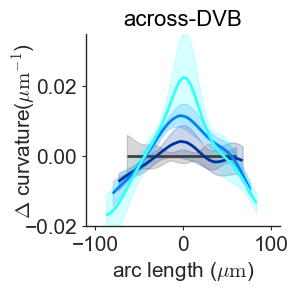

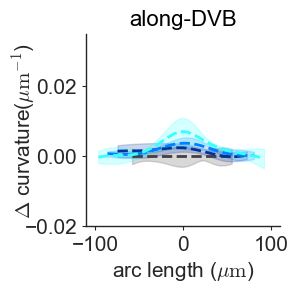

In [146]:

for region in ['acrossDV','alongDV']:
    fig, ax = plt.subplots(figsize = (2.5,2.5))
    for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
   
        if region == 'alongDV': 
                style = '--' 
                title = 'along-DVB'
        else:
            style = '-'  
            title = 'across-DVB'

        toplot = InterpolatedValues.loc[(InterpolatedValues['devstage']==devstage)&(InterpolatedValues['region']==region)]
        ax.plot(toplot['arclength'],toplot['mean'], color = colors[devstage], linestyle = style,lw = 2)
        ax.fill_between(toplot['arclength'],y1 = toplot['mean']-toplot['std'],y2 = toplot['mean']+toplot['std'], color = colors[devstage], alpha = 0.2)

        ax.set_xlim(-110,110)
        ax.set_ylim(-0.02,0.035)
        
        xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
        ax.set_xlabel(xlabel, rotation = 'horizontal')

        # ylabel = 'curvature ' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
        ylabel = r'$\mathrm{\Delta}$' + ' curvature' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
        ax.set_ylabel(ylabel, rotation = 'vertical', labelpad = -10) 
        ax.set_title(title)
    plt.savefig(dataout + 'Data_curvatureChange_arc_um_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')

# WT model results

### plot changes in curvature

/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_83753/3844642425.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_83753/3844642425.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_83753/3844642425.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()
/var/folders/kz/v3hfj4tj1

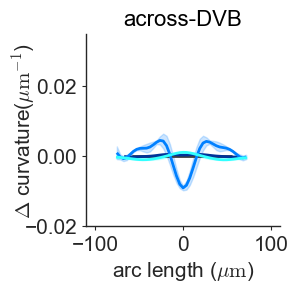

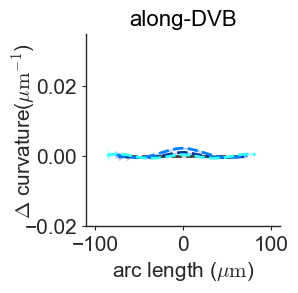

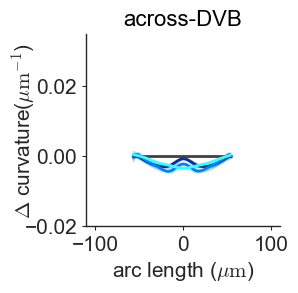

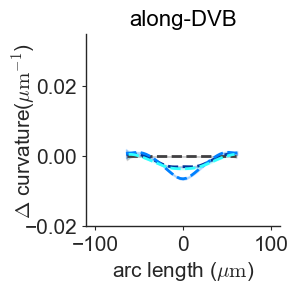

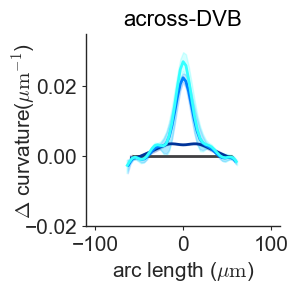

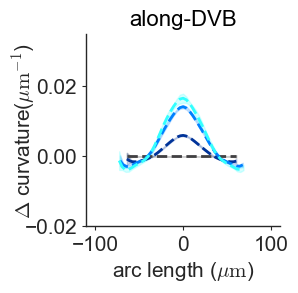

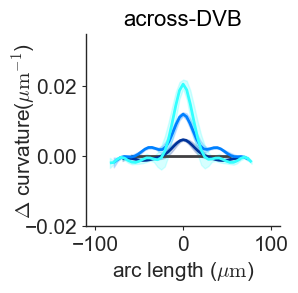

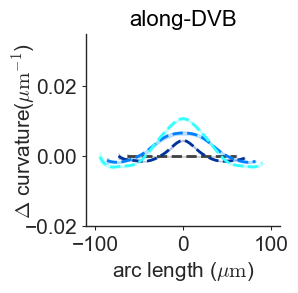

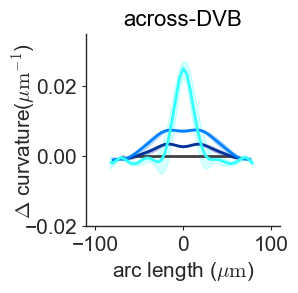

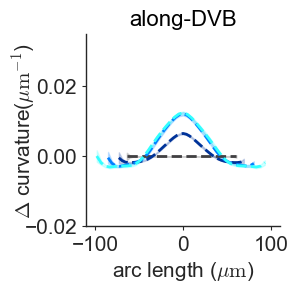

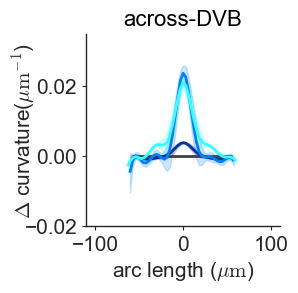

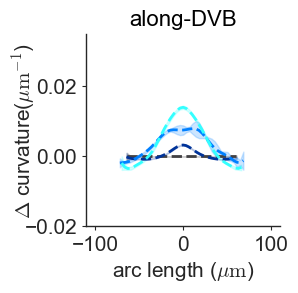

In [159]:
for cond in ['AreaOnly', 'Elongation', 'Rearrangements', 'allWT','area_rearrangement','elongation_rearrangement','rearrangement_area_corrected']:
    ylim = (-0.005,0.045)
    if cond == 'AreaOnly':
        folder = 'area'
    if cond == 'Elongation':
        folder = 'elongation'
    if cond == 'area_rearrangement':
       folder = 'area_rearrangement'   
    if cond == 'elongation_rearrangement':
       folder = 'elongation_rearrangement'   
    if cond == 'Rearrangements':
        folder = 'rearrangement'
        ylim = (-0.005,0.105)
    if cond == 'allWT':
        folder = 'all'
    if cond == 'rearrangement_area_corrected':
        folder = 'rearrangement_area_corrected'
        
    filepath = '/Users/fuhrmann/workspace/wdeversion_paper/Simulation_data/WT/'+ folder + '/analysis/'
    file = filepath + 'crosssections_interpolated_all.csv'
    Model_Results = pd.read_csv(file)

    Model_Results.loc[Model_Results['crosssection']=='Across_DV', 'region'] = 'acrossDV'
    Model_Results.loc[Model_Results['crosssection']=='Along_DV', 'region'] = 'alongDV'
    Model_Results = Model_Results.loc[Model_Results['thickness'] == 0.10]


    g = Model_Results.groupby(['devstage','region','disc']).agg({'arclength':['min', 'max']}).reset_index()
    colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in g.columns]
    g.columns = colnames #removing multi-indexing
    Model_Results = pd.merge(Model_Results,g)
    Model_Results.loc[Model_Results['arclength'] < 0, 'arclength_norm'] = -(Model_Results['arclength'] / Model_Results['arclength_min'])
    Model_Results.loc[Model_Results['arclength'] > 0, 'arclength_norm'] = (Model_Results['arclength'] / Model_Results['arclength_max'])
    backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()

    columns = ['disc', 'devstage','region','arc_interpolate','curvature_interpolate']
    InterpolatedValues = pd.DataFrame(columns=columns)
    arc_interpolate = np.arange(-1,1,0.05)

    for devstage in devstages: 
        for region in ['acrossDV','alongDV']:
            for disc in np.unique(Model_Results.loc[(Model_Results['devstage'] == devstage)&(Model_Results['region'] == region)]['disc']):

                xs = Model_Results.loc[(Model_Results['devstage'] == devstage)&(Model_Results['region'] == region)&(Model_Results['disc'] == disc)]['arclength_norm'].tolist()
                ys = Model_Results.loc[(Model_Results['devstage'] == devstage)&(Model_Results['region'] == region)&(Model_Results['disc'] == disc)]['curvature'].tolist()
                curvature_interpolate = piecewise_linear_interpolate(arc_interpolate, xs, ys, manner = 'linear', include_zero = False)
                
                for i in range(0,len(arc_interpolate)):
                    row = pd.DataFrame([[disc, devstage, region, arc_interpolate[i],curvature_interpolate[i]]], columns=columns)
                    InterpolatedValues = pd.concat([InterpolatedValues, row], ignore_index = True)
                    
    baseline = InterpolatedValues.loc[InterpolatedValues['devstage']=='wL3'].groupby(['arc_interpolate','region'])['curvature_interpolate'].agg('mean').reset_index().rename(columns={'curvature_interpolate':'baseline'})

    InterpolatedValues = pd.merge(InterpolatedValues,baseline)
    InterpolatedValues['curvature_change'] = InterpolatedValues['curvature_interpolate'] - InterpolatedValues['baseline']
    InterpolatedValues = InterpolatedValues.groupby(['devstage','region','arc_interpolate'])['curvature_change'].agg(['mean','std']).reset_index()

    InterpolatedValues = pd.merge(InterpolatedValues,backCalc)
    InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] < 0, 'arclength'] = -(InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_min'])
    InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] > 0, 'arclength'] = (InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_max'])

    for region in ['acrossDV','alongDV']:
        fig, ax = plt.subplots(figsize = (2.5,2.5))
        for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
    
            if region == 'alongDV': 
                    style = '--' 
                    title = 'along-DVB'
            else:
                style = '-'  
                title = 'across-DVB'

            toplot = InterpolatedValues.loc[(InterpolatedValues['devstage']==devstage)&(InterpolatedValues['region']==region)]
            ax.plot(toplot['arclength'],toplot['mean'], color = colors[devstage], linestyle = style,lw = 2)
            ax.fill_between(toplot['arclength'],y1 = toplot['mean']-toplot['std'],y2 = toplot['mean']+toplot['std'], color = colors[devstage], alpha = 0.2)

            ax.set_xlim(-110,110)
            ax.set_ylim(-0.02,0.035)
            
            xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
            ax.set_xlabel(xlabel, rotation = 'horizontal')

            ylabel = r'$\mathrm{\Delta}$' + ' curvature' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
            ax.set_ylabel(ylabel, rotation = 'vertical', labelpad = -10) 
            ax.set_title(title)
        
            plt.savefig(dataout + 'Model_curvatureChange_arc_um_' + cond + '_curvatureOverlay_eversion_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')


### plot absolute curvature -old

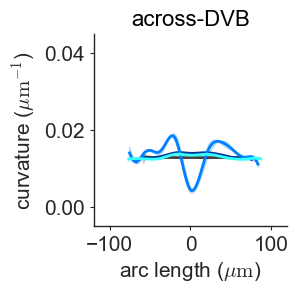

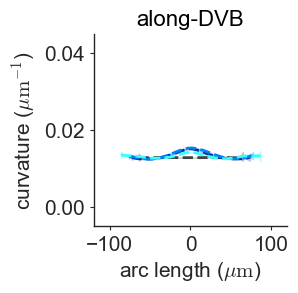

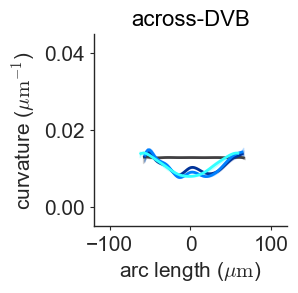

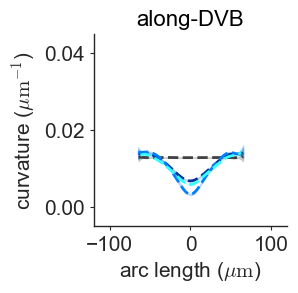

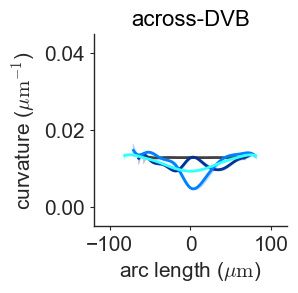

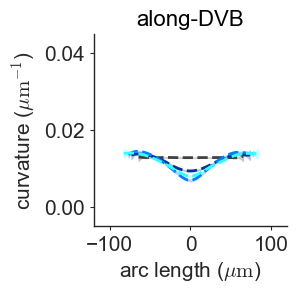

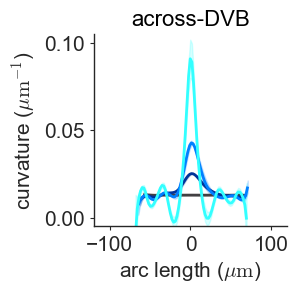

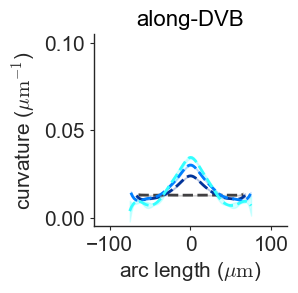

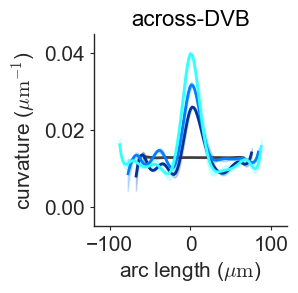

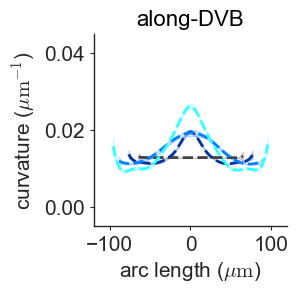

In [23]:
#### This is the import from only 5 simulations

for cond in ['AreaOnly', 'Elongation', 'AreaElongation', 'Rearrangements', 'allWT']:
    ylim = (-0.005,0.045)
    if cond == 'AreaOnly':
        folder = 'Only_Area_Contribution'
    if cond == 'Elongation':
        folder = 'Only_Elongation_Contribution'
    if cond == 'AreaElongation':
        folder = 'Area_Elongation_Contribution'   
    if cond == 'Rearrangements':
        folder = 'Only_Rearrangement_Contribution'
        ylim = (-0.005,0.105)
    if cond == 'allWT':
        folder = 'WT_simulation'
        
    filepath = '/Users/fuhrmann/workspace/WingDiscEversion_theory/Simulations/different_conditions/'+ folder + '/mesh_refine_factor_30/analysis/'
    file = filepath + 'crosssections_interpolated_mean.csv'
    Model_Results = pd.read_csv(file)

    Model_Results.loc[Model_Results['crosssection']=='Across_DV', 'region'] = 'acrossDV'
    Model_Results.loc[Model_Results['crosssection']=='Along_DV', 'region'] = 'alongDV'
    Model_Results = Model_Results.loc[Model_Results['thickness'] == 0.10]


    for region in ['acrossDV','alongDV']:
        fig, ax = plt.subplots(figsize = (2.5,2.5))
        for i in range (0,4):
            devstage = ['wL3','0hAPF','2hAPF','4hAPF'][i]
            
            if region == 'alongDV': 
                    style = '--' 
                    title = 'along-DVB'
            else:
                style = '-'  
                title = 'across-DVB'

        
            toplot = Model_Results.loc[(Model_Results['devstage']==devstage)&(Model_Results['region']==region)]
            
            ax.fill_between(toplot['arclength'],y1 = toplot['curvature']-toplot['curvature_sd'],y2 = toplot['curvature']+toplot['curvature_sd'], color = colors[devstage], alpha = 0.2)

            ax.plot(toplot['arclength'],toplot['curvature'], color = colors[devstage], linestyle = style,lw = 2)

            ax.set_xlim(-120,120)
            ax.set_ylim(ylim)
            xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
            ax.set_xlabel(xlabel, rotation = 'horizontal')

            ylabel = 'curvature ' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
            ax.set_ylabel(ylabel, rotation = 'vertical') 
            ax.set_title(title)
        plt.savefig(dataout + 'Model_' + cond + '_curvatureOverlay_eversion_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')

## MyoVI results

In [8]:
genotype = 'ecadGFPnbG4myoVI'

### plot absolute curvature -old

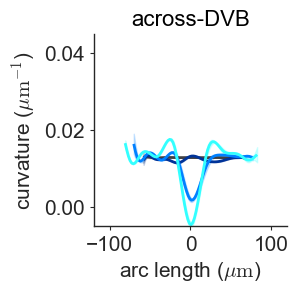

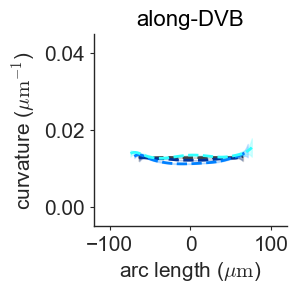

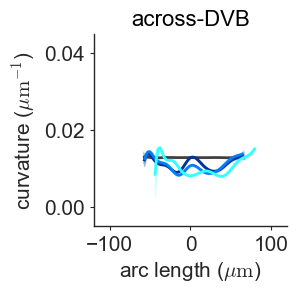

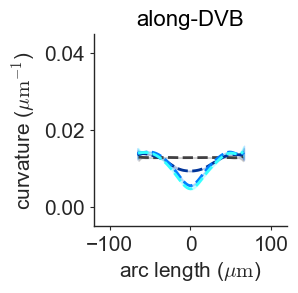

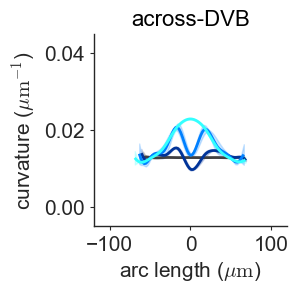

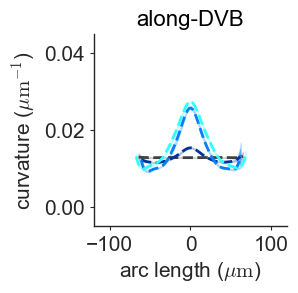

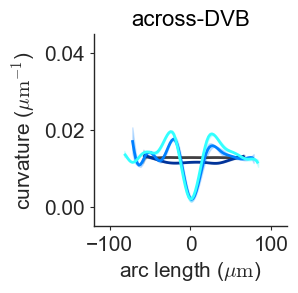

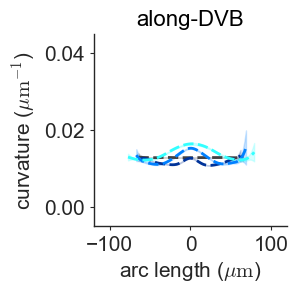

In [24]:

for cond in ['Area', 'Elongation', 'Rearrangements', 'allMyoVI']:
    ylim = (-0.005,0.045)
    if cond == 'Area':
        folder = 'MyoVI/Only_Area'
    if cond == 'Elongation':
        folder = 'MyoVI/Only_Elongation'
    if cond == 'Rearrangements':
        folder = 'MyoVI/Only_Rearrangement'
    if cond == 'allMyoVI':
        folder = 'all'
        
    filepath = '/Users/fuhrmann/workspace/WingDiscEversion_theory/Simulations/different_conditions/'+ folder + '/analysis/'
    file = filepath + 'crosssections_interpolated_mean.csv'
    Model_Results = pd.read_csv(file)

    Model_Results.loc[Model_Results['crosssection']=='Across_DV', 'region'] = 'acrossDV'
    Model_Results.loc[Model_Results['crosssection']=='Along_DV', 'region'] = 'alongDV'
    Model_Results = Model_Results.loc[Model_Results['thickness'] == 0.10]


    for region in ['acrossDV','alongDV']:
        fig, ax = plt.subplots(figsize = (2.5,2.5))
        for i in range (0,4):
            devstage = ['wL3','0hAPF','2hAPF','4hAPF'][i]
            
            if region == 'alongDV': 
                    style = '--' 
                    title = 'along-DVB'
            else:
                style = '-'  
                title = 'across-DVB'

        
            toplot = Model_Results.loc[(Model_Results['devstage']==devstage)&(Model_Results['region']==region)]
            
            ax.fill_between(toplot['arclength'],y1 = toplot['curvature']-toplot['curvature_sd'],y2 = toplot['curvature']+toplot['curvature_sd'], color = colors[devstage], alpha = 0.2)

            ax.plot(toplot['arclength'],toplot['curvature'], color = colors[devstage], linestyle = style,lw = 2)

            ax.set_xlim(-120,120)
            ax.set_ylim(ylim)
            xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
            ax.set_xlabel(xlabel, rotation = 'horizontal')

            ylabel = 'curvature ' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
            ax.set_ylabel(ylabel, rotation = 'vertical') 
            ax.set_title(title)
        plt.savefig(dataout + 'Model_' + cond + '_curvatureOverlay_eversion_' +genotype +'_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')

### plot changes in curvature

/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_90626/2566739076.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_90626/2566739076.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_90626/2566739076.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()
/var/folders/kz/v3hfj4tj1

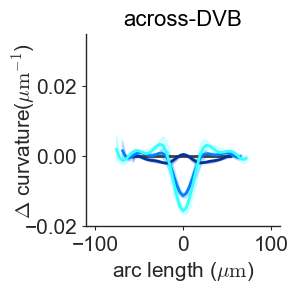

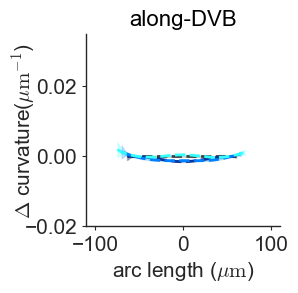

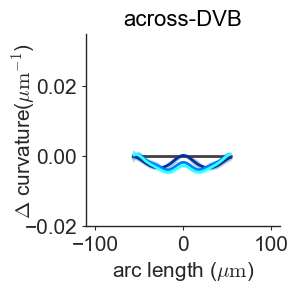

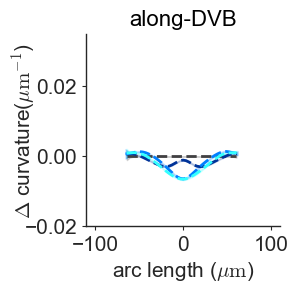

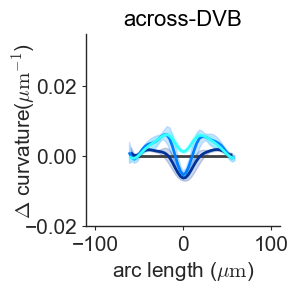

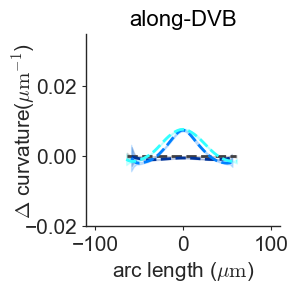

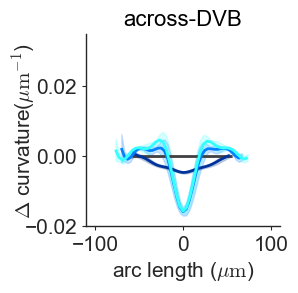

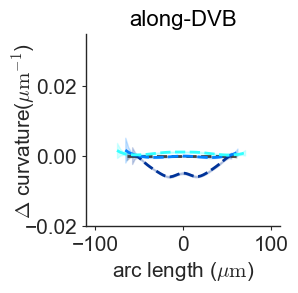

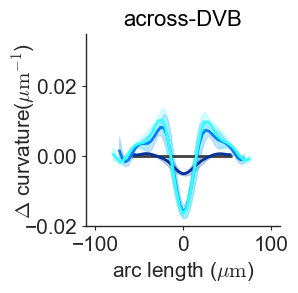

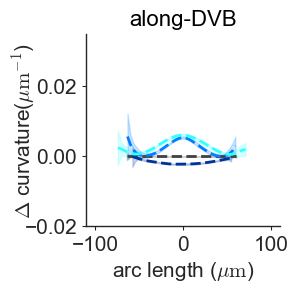

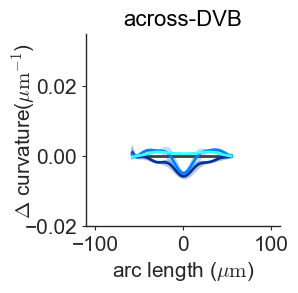

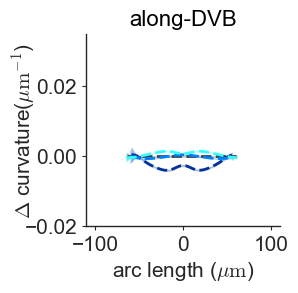

In [9]:
for cond in ['AreaOnly', 'Elongation', 'Rearrangements', 'allMyoVI','area_rearrangement','elongation_rearrangement']:
    ylim = (-0.005,0.045)
    if cond == 'AreaOnly':
        folder = 'area'
    if cond == 'Elongation':
        folder = 'elongation'
    if cond == 'area_rearrangement':
       folder = 'area_rearrangement'   
    if cond == 'elongation_rearrangement':
       folder = 'elongation_rearrangement'   
    if cond == 'Rearrangements':
        folder = 'rearrangement'
        ylim = (-0.005,0.105)
    if cond == 'allMyoVI':
        folder = 'all'
        
    filepath = '/Users/fuhrmann/workspace/wdeversion_paper/Simulation_data/Myo/'+ folder + '/analysis/'
    file = filepath + 'crosssections_interpolated_all.csv'
    Model_Results = pd.read_csv(file)

    Model_Results.loc[Model_Results['crosssection']=='Across_DV', 'region'] = 'acrossDV'
    Model_Results.loc[Model_Results['crosssection']=='Along_DV', 'region'] = 'alongDV'
    Model_Results = Model_Results.loc[Model_Results['thickness'] == 0.10]


    g = Model_Results.groupby(['devstage','region','disc']).agg({'arclength':['min', 'max']}).reset_index()
    colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in g.columns]
    g.columns = colnames #removing multi-indexing
    Model_Results = pd.merge(Model_Results,g)
    Model_Results.loc[Model_Results['arclength'] < 0, 'arclength_norm'] = -(Model_Results['arclength'] / Model_Results['arclength_min'])
    Model_Results.loc[Model_Results['arclength'] > 0, 'arclength_norm'] = (Model_Results['arclength'] / Model_Results['arclength_max'])
    backCalc = Model_Results.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()

    columns = ['disc', 'devstage','region','arc_interpolate','curvature_interpolate']
    InterpolatedValues = pd.DataFrame(columns=columns)
    arc_interpolate = np.arange(-1,1,0.05)

    for devstage in devstages: 
        for region in ['acrossDV','alongDV']:
            for disc in np.unique(Model_Results.loc[(Model_Results['devstage'] == devstage)&(Model_Results['region'] == region)]['disc']):

                xs = Model_Results.loc[(Model_Results['devstage'] == devstage)&(Model_Results['region'] == region)&(Model_Results['disc'] == disc)]['arclength_norm'].tolist()
                ys = Model_Results.loc[(Model_Results['devstage'] == devstage)&(Model_Results['region'] == region)&(Model_Results['disc'] == disc)]['curvature'].tolist()
                curvature_interpolate = piecewise_linear_interpolate(arc_interpolate, xs, ys, manner = 'linear', include_zero = False)
                
                for i in range(0,len(arc_interpolate)):
                    row = pd.DataFrame([[disc, devstage, region, arc_interpolate[i],curvature_interpolate[i]]], columns=columns)
                    InterpolatedValues = pd.concat([InterpolatedValues, row], ignore_index = True)
                    
    baseline = InterpolatedValues.loc[InterpolatedValues['devstage']=='wL3'].groupby(['arc_interpolate','region'])['curvature_interpolate'].agg('mean').reset_index().rename(columns={'curvature_interpolate':'baseline'})

    InterpolatedValues = pd.merge(InterpolatedValues,baseline)
    InterpolatedValues['curvature_change'] = InterpolatedValues['curvature_interpolate'] - InterpolatedValues['baseline']
    InterpolatedValues = InterpolatedValues.groupby(['devstage','region','arc_interpolate'])['curvature_change'].agg(['mean','std']).reset_index()

    InterpolatedValues = pd.merge(InterpolatedValues,backCalc)
    InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] < 0, 'arclength'] = -(InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_min'])
    InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] > 0, 'arclength'] = (InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_max'])

    for region in ['acrossDV','alongDV']:
        fig, ax = plt.subplots(figsize = (2.5,2.5))
        for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
    
            if region == 'alongDV': 
                    style = '--' 
                    title = 'along-DVB'
            else:
                style = '-'  
                title = 'across-DVB'

            toplot = InterpolatedValues.loc[(InterpolatedValues['devstage']==devstage)&(InterpolatedValues['region']==region)]
            ax.plot(toplot['arclength'],toplot['mean'], color = colors[devstage], linestyle = style,lw = 2)
            ax.fill_between(toplot['arclength'],y1 = toplot['mean']-toplot['std'],y2 = toplot['mean']+toplot['std'], color = colors[devstage], alpha = 0.2)

            ax.set_xlim(-110,110)
            ax.set_ylim(-0.02,0.035)
            
            xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
            ax.set_xlabel(xlabel, rotation = 'horizontal')

            ylabel = r'$\mathrm{\Delta}$' + ' curvature' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
            ax.set_ylabel(ylabel, rotation = 'vertical', labelpad = -10) 
            ax.set_title(title)
        
            plt.savefig(dataout + 'Model_curvatureChange_arc_um_' + cond + '_curvatureOverlay_eversion_' + genotype + '_' + region +  '.pdf', dpi = 600, bbox_inches = 'tight')


In [162]:
#Dataframe that contains all crossections from ecadGFPnbG4 and ecadGFPnbG4myoVI
with open('allshapeswStats.pkl','rb') as f:
        df_mean_all = pickle.load(f)

print('data for the following genotypes is available: '+ str(np.unique(df_mean_all['genotype'])))
genotype='ecadGFPnbG4myoVI'
df_mean_all["devstage"] = [devstage_map[x] for x in df_mean_all["devstage"].values]
df_mean = df_mean_all.loc[df_mean_all['genotype']==genotype]

data for the following genotypes is available: ['ecadGFPnbG4' 'ecadGFPnbG4myoVI']


In [163]:
df_mean = df_mean[['arclength','devstage','x_mean','y_mean','x_std','y_std','curvature_mean','curvature_std','region']]

In [164]:
### Set path to directory containing the Tissue Miner movies
import os
datapath_base = '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/data/'

with open(datapath_base + 'DFallDiscs' + 'limitcounts.pkl','rb') as f:
   allDiscsSorted = pickle.load(f)
allDiscsSorted = allDiscsSorted[allDiscsSorted['genotype'] == genotype]
allDiscsSorted["devstage"] = [devstage_map[x] for x in allDiscsSorted["devstage"].values]



In [56]:
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['dorsal','ventral']),'region'] = 'outDV'
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['DV']),'region'] = 'DV'

cellshapes = allDiscsSorted[(allDiscsSorted['genotype']==genotype)]
cellshapes = cellshapes.groupby(['devstage','discName','k_dist','region'])['k_dist_pathlength'].agg('mean').reset_index()
cellshapes = cellshapes.groupby(['devstage','discName','region'])['k_dist_pathlength'].agg('max').reset_index()

cellshapes = cellshapes.groupby(['devstage','region'])['k_dist_pathlength'].agg(['mean','std']).reset_index().rename(columns = {'mean':'maxPathlength'})

# if orientation == 'Across_DV':
with open(datapath_base+ 'DVboundaryWidth.pkl','rb') as f:
                DVwidth = pickle.load(f)
DVwidth = DVwidth[DVwidth['genotype']==genotype].groupby(['devstage'])['pathlengthUM'].agg(['mean']).rename(columns={'mean':'meanDVwidth'}).reset_index()
DVwidth["devstage"] = [devstage_map[x] for x in DVwidth["devstage"].values]
cellshapes = cellshapes.merge(DVwidth)
cellshapes.loc[cellshapes['region']=='outDV', 'maxPathlength'] = cellshapes['maxPathlength'] + (1/2*cellshapes['meanDVwidth'])
cellshapes.loc[cellshapes['region']=='DV','region'] = 'alongDV'
cellshapes.loc[cellshapes['region']=='outDV','region'] = 'acrossDV'

df_mean_all_trunkated = df_mean.merge(cellshapes)
df_mean_all_trunkated['trunkated'] = np.where((abs(df_mean_all_trunkated['arclength']) <= (df_mean_all_trunkated['maxPathlength']+df_mean_all_trunkated['std'])), 'keep', np.nan)
df_mean_all_trunkated = df_mean_all_trunkated[df_mean_all_trunkated['trunkated']=='keep'].drop(columns=['trunkated'])            
df_mean_all_trunkated = df_mean_all_trunkated.drop(columns=['std','meanDVwidth','maxPathlength'])

df_mean_all_trunkated = df_mean_all_trunkated.sort_values('arclength')
df_mean_all_trunkated = df_mean_all_trunkated.drop_duplicates()

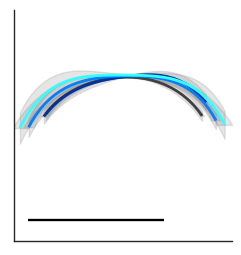

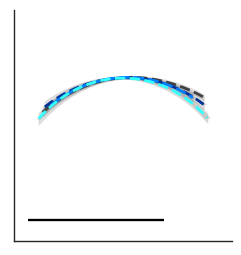

In [57]:

for region in ['acrossDV','alongDV']:
    fig, ax = plt.subplots(figsize = (3,3))
    
    for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
    
        if region == 'alongDV': 
                style = '--' 
        else:
            style = '-'

        toplot = df_mean_all_trunkated.loc[(df_mean_all_trunkated['devstage']==devstage)&(df_mean_all_trunkated['region']==region)]
        ax.plot(toplot['x_mean'],toplot['y_mean'], color = colors[devstage], linestyle = style,lw = 2)
        ax.fill_between(toplot['x_mean'],y1 = toplot['y_mean']-toplot['y_std'],y2 = toplot['y_mean']+toplot['y_std'], color = 'grey', alpha = 0.2)
        ax.fill_betweenx(y = toplot['y_mean'],x1 = toplot['x_mean']-toplot['x_std'],x2 = toplot['x_mean']+toplot['x_std'], color = 'grey', alpha = 0.2)
 
        ax.set_xlim(-80,80)
        ax.set_ylim(-120,50)
        ax.set_yticks([])
        ax.set_xticks([])
        # ax.spines['top'].set_visible(True)
        # ax.spines['right'].set_visible(True)
        #adding scale bar
        ax.plot([-80*7/8, -80*7/8+100],[-120*7/8,-120*7/8], lw = 1.5, color = 'black')       
        ax.set_aspect('equal')
    plt.savefig(dataout + genotype + '_' + region +  '_shapeOverlay_eversion_trunkated.pdf', dpi = 600, bbox_inches = 'tight')

In [180]:
### Set path to directory containing the Tissue Miner movies
import os
datapath_base = '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/data/'

with open(datapath_base + 'DFallDiscs' + 'limitcounts.pkl','rb') as f:
   allDiscsSorted = pickle.load(f)
allDiscsSorted = allDiscsSorted[allDiscsSorted['genotype'] == genotype]
allDiscsSorted["devstage"] = [devstage_map[x] for x in allDiscsSorted["devstage"].values]



In [181]:
#Dataframe that contains all crossections from ecadGFPnbG4 and ecadGFPnbG4myoVI
with open('allshapes.pkl','rb') as f:
        df_all = pickle.load(f)

print('data for the following genotypes is available: '+ str(np.unique(df_all['genotype'])))

df_all["devstage"] = [devstage_map[x] for x in df_all["devstage"].values]
df_shape = df_all.loc[df_all['genotype']==genotype]

data for the following genotypes is available: ['ecadGFPnbG4' 'ecadGFPnbG4myoVI']


In [182]:
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['dorsal','ventral']),'region'] = 'outDV'
allDiscsSorted.loc[allDiscsSorted['roi'].isin(['DV']),'region'] = 'DV'
allDiscsSorted['disc'] = [allDiscsSorted['disc'].values[i][:-2] for i in range(0,len(allDiscsSorted))]

cellshapes = allDiscsSorted[(allDiscsSorted['genotype']==genotype)]
cellshapes = cellshapes.groupby(['devstage','discName','k_dist','region','disc'])['k_dist_pathlength'].agg('mean').reset_index()
cellshapes = cellshapes.groupby(['devstage','discName','region','disc'])['k_dist_pathlength'].agg('max').reset_index().rename(columns = {'k_dist_pathlength':'maxPathlength'})


with open(datapath_base+ 'DVboundaryWidth.pkl','rb') as f:
                DVwidth = pickle.load(f)
DVwidth = DVwidth[DVwidth['genotype']==genotype].groupby(['devstage'])['pathlengthUM'].agg(['mean']).rename(columns={'mean':'meanDVwidth'}).reset_index()
DVwidth["devstage"] = [devstage_map[x] for x in DVwidth["devstage"].values]
cellshapes = cellshapes.merge(DVwidth)
cellshapes.loc[cellshapes['region']=='outDV', 'maxPathlength'] = cellshapes['maxPathlength'] + (1/2*cellshapes['meanDVwidth'])


cellshapes.loc[cellshapes['region']=='DV','region'] = 'alongDV'
cellshapes.loc[cellshapes['region']=='outDV','region'] = 'acrossDV'
df_shape_trunkated = df_shape.merge(cellshapes)
df_shape_trunkated['trunkated'] = np.where((abs(df_shape_trunkated['arclength']) <= (df_shape_trunkated['maxPathlength'])), 'keep', np.nan)
df_shape_trunkated = df_shape_trunkated[df_shape_trunkated['trunkated']=='keep'].drop(columns=['trunkated'])            
df_shape_trunkated = df_shape_trunkated.drop(columns=['discName','meanDVwidth','maxPathlength'])
df_shape_trunkated = df_shape_trunkated.drop_duplicates()


g = df_shape_trunkated.groupby(['devstage','region','disc']).agg({'arclength':['min', 'max']}).reset_index()
colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in g.columns]
g.columns = colnames #removing multi-indexing
df_shape_trunkated = pd.merge(df_shape_trunkated,g)
df_shape_trunkated.loc[df_shape_trunkated['arclength'] < 0, 'arclength_norm'] = -(df_shape_trunkated['arclength'] / df_shape_trunkated['arclength_min'])
df_shape_trunkated.loc[df_shape_trunkated['arclength'] > 0, 'arclength_norm'] = (df_shape_trunkated['arclength'] / df_shape_trunkated['arclength_max'])
backCalc = df_shape_trunkated.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()

columns = ['disc', 'devstage','region','arc_interpolate','curvature_interpolate']
InterpolatedValues = pd.DataFrame(columns=columns)
arc_interpolate = np.arange(-1,1,0.05)

for devstage in devstages: 
    for region in ['acrossDV','alongDV']:
        for disc in np.unique(df_shape_trunkated.loc[(df_shape_trunkated['devstage'] == devstage)&(df_shape_trunkated['region'] == region)]['disc']):

            xs = df_shape_trunkated.loc[(df_shape_trunkated['devstage'] == devstage)&(df_shape_trunkated['region'] == region)&(df_shape_trunkated['disc'] == disc)]['arclength_norm'].tolist()
            ys = df_shape_trunkated.loc[(df_shape_trunkated['devstage'] == devstage)&(df_shape_trunkated['region'] == region)&(df_shape_trunkated['disc'] == disc)]['curvature'].tolist()
            curvature_interpolate = piecewise_linear_interpolate(arc_interpolate, xs, ys, manner = 'linear', include_zero = False)
            
            for i in range(0,len(arc_interpolate)):
                row = pd.DataFrame([[disc, devstage, region, arc_interpolate[i],curvature_interpolate[i]]], columns=columns)
                InterpolatedValues = pd.concat([InterpolatedValues, row], ignore_index = True)
                
baseline = InterpolatedValues.loc[InterpolatedValues['devstage']=='wL3'].groupby(['arc_interpolate','region'])['curvature_interpolate'].agg('mean').reset_index().rename(columns={'curvature_interpolate':'baseline'})

InterpolatedValues = pd.merge(InterpolatedValues,baseline)
InterpolatedValues['curvature_change'] = InterpolatedValues['curvature_interpolate'] - InterpolatedValues['baseline']
InterpolatedValues = InterpolatedValues.groupby(['devstage','region','arc_interpolate'])['curvature_change'].agg(['mean','std']).reset_index()

InterpolatedValues = pd.merge(InterpolatedValues,backCalc)
InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] < 0, 'arclength'] = -(InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_min'])
InterpolatedValues.loc[InterpolatedValues['arc_interpolate'] > 0, 'arclength'] = (InterpolatedValues['arc_interpolate'] * InterpolatedValues['arclength_max'])

/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_83753/1769093159.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  backCalc = df_shape_trunkated.groupby(['devstage','region'])['arclength_min','arclength_max'].agg('mean').reset_index()


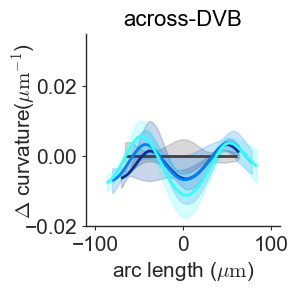

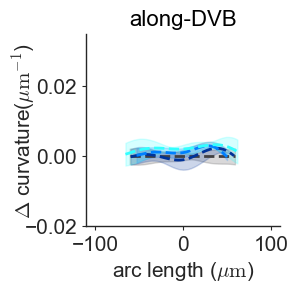

In [185]:

for region in ['acrossDV','alongDV']:
    fig, ax = plt.subplots(figsize = (2.5,2.5))
    for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
   
        if region == 'alongDV': 
                style = '--' 
                title = 'along-DVB'
        else:
            style = '-'  
            title = 'across-DVB'

        toplot = InterpolatedValues.loc[(InterpolatedValues['devstage']==devstage)&(InterpolatedValues['region']==region)]
        ax.plot(toplot['arclength'],toplot['mean'], color = colors[devstage], linestyle = style,lw = 2)
        ax.fill_between(toplot['arclength'],y1 = toplot['mean']-toplot['std'],y2 = toplot['mean']+toplot['std'], color = colors[devstage], alpha = 0.2)

        ax.set_xlim(-110,110)
        ax.set_ylim(-0.02,0.035)
        
        xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
        ax.set_xlabel(xlabel, rotation = 'horizontal')

        # ylabel = 'curvature ' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
        ylabel = r'$\mathrm{\Delta}$' + ' curvature' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
        ax.set_ylabel(ylabel, rotation = 'vertical', labelpad = -10) 
        ax.set_title(title)
    plt.savefig(dataout + genotype +  '_Data_curvatureOverlay_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')

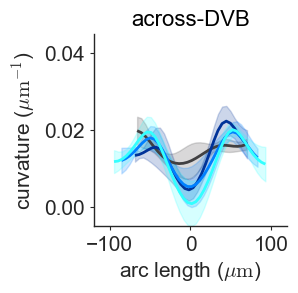

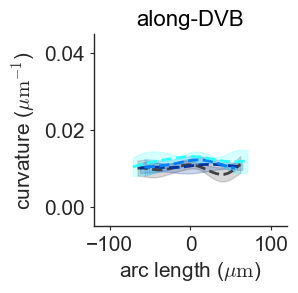

In [58]:
for region in ['acrossDV','alongDV']:
    fig, ax = plt.subplots(figsize = (2.5,2.5))
    for devstage in ['wL3','0hAPF','2hAPF','4hAPF']:
   
        if region == 'alongDV': 
                style = '--' 
                title = 'along-DVB'
        else:
            style = '-'  
            title = 'across-DVB'

        toplot = df_mean_all_trunkated.loc[(df_mean_all_trunkated['devstage']==devstage)&(df_mean_all_trunkated['region']==region)]
        ax.plot(toplot['arclength'],toplot['curvature_mean'], color = colors[devstage], linestyle = style,lw = 2)
        ax.fill_between(toplot['arclength'],y1 = toplot['curvature_mean']-toplot['curvature_std'],y2 = toplot['curvature_mean']+toplot['curvature_std'], color = colors[devstage], alpha = 0.2)
        

        ax.set_xlim(-120,120)
        ax.set_ylim(-0.005,0.045)
        xlabel = 'arc length ' + '(' + r'$\mathrm{\mu m}$' + ')'
        ax.set_xlabel(xlabel, rotation = 'horizontal')

        ylabel = 'curvature ' + '(' + r'$\mathrm{\mu m^{-1}}$' + ')'
        ax.set_ylabel(ylabel, rotation = 'vertical') 
        ax.set_title(title)

    plt.savefig(dataout + genotype +  '_Data_curvatureOverlay_' + region + '.pdf', dpi = 600, bbox_inches = 'tight')